# Импорт библиотек

In [1]:
import sys
print(sys.executable)
print(sys.version)

c:\Users\khomy\Desktop\MLOPS_course_work_Ksusha_edition\clean_mlops\Scripts\python.exe
3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]


Установить нужные библиотеки 

Поменять пути надо будет на свои

`C:\Users\Smart\PycharmProjects\MLOPS_Ksusha\clean_mlops\Scripts\python.exe -m pip install -r C:\Users\Smart\PycharmProjects\MLOPS_Ksusha\requirements.txt`

In [2]:
# Стандартные библиотеки
import re
import time
from functools import lru_cache
from collections import Counter
import warnings

# Для работы с данными и визуализации
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для работы с машинным обучением (классические модели)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


# Для обработки текста
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# TensorFlow / Keras (для LSTM, CNN и других нейронных сетей)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, SpatialDropout1D,
    Conv1D, GlobalMaxPooling1D, Concatenate, Input
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Настройки
warnings.filterwarnings('ignore')

# Загрузка nltk ресурсов
for resource in ['punkt', 'stopwords', 'wordnet']:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource=='punkt' else f'corpora/{resource}')
    except LookupError:
        nltk.download(resource)


import mlflow
from mlflow import MlflowClient
from omegaconf import OmegaConf
import os

import joblib
import mlflow.keras

from datasets import Dataset
import json
import pickle

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khomy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Запуск MLFLOW server

`mlflow server --port 8080 --host 127.0.0.1`



In [3]:
mlflow.set_tracking_uri('http://localhost:8080')

# Настройка параметризации

In [24]:
# Загрузка конфигурации
def load_config(config_name):
    config_path = f"config/{config_name}.yml"
    
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Конфигурационный файл {config_path} не найден")
    
    cfg = OmegaConf.load(config_path)
    
    if 'MLFLOW_TRACKING_URI' in os.environ:
        cfg.mlflow.tracking_uri = os.environ['MLFLOW_TRACKING_URI']
    
    return cfg

# Эксперименты с датасетами

## 1 эксперимент (Чистые данные)

Размер датасета: (416809, 2)

Первые 3 строки:
                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4

Распределение классов:
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


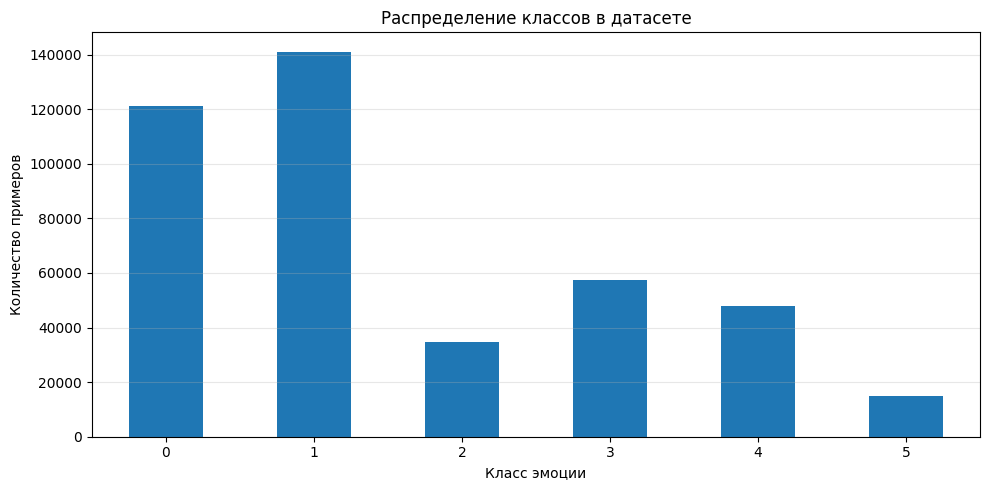

In [15]:
# Загружаем конфиг
cfg = load_config("first_dataset_experiment")

# Настройка MLflow
mlflow.set_tracking_uri(cfg.mlflow.tracking_uri)
mlflow.set_experiment(experiment_id=cfg.mlflow.experiment_name)

# Старт run с параметрами из конфига
with mlflow.start_run(run_name=cfg.mlflow.run_name):
    
    # Устанавливаем все теги из конфига
    for tag_key, tag_value in cfg.mlflow.tags.items():
        mlflow.set_tag(tag_key, tag_value)
    
    # Загрузка данных с параметрами из конфига
    df = pd.read_csv(
        cfg.data.input.path,
        sep=cfg.data.input.delimiter,
        encoding=cfg.data.input.encoding
    )
    
    # Получаем названия колонок из конфига
    text_column = cfg.data.input.columns.text
    label_column = cfg.data.input.columns.label
    
    print(f"Размер датасета: {df.shape}")
    print(f"\nПервые 3 строки:")
    print(df.head(3))
    print(f"\nРаспределение классов:")
    print(df[label_column].value_counts())
    
    # Визуализация распределения классов
    plt.figure(figsize=(10, 5))
    df[label_column].value_counts().sort_index().plot(kind='bar')
    plt.title('Распределение классов в датасете')
    plt.xlabel('Класс эмоции')
    plt.ylabel('Количество примеров')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Сохраняем визуализацию
    viz_filename = 'class_distribution.png'
    plt.savefig(viz_filename)
    plt.show()
    
    # Логирование артефактов
    mlflow.log_artifact(cfg.data.input.path, 'data')
    mlflow.log_artifact(viz_filename, 'viz')
    
    # Сохранение обработанных данных (если нужно)
    if cfg.data.output.save_processed:
        if cfg.data.output.include_original:
            df.to_csv(cfg.data.output.path, index=False)
        else:
            # Можно добавить препроцессинг здесь
            df[[text_column, label_column]].to_csv(cfg.data.output.path, index=False)
        
        # Логируем обработанные данные
        mlflow.log_artifact(cfg.data.output.path, 'data')
 
    
    # Логируем метрики (распределение классов)
    class_distribution = df[label_column].value_counts().to_dict()
    for class_label, count in class_distribution.items():
        mlflow.log_metric(f"class_{class_label}_count", count)

## 2 эксперимент (Очистка + Лемматизация)

In [16]:
from tqdm import tqdm
tqdm.pandas()

# Загружаем конфиг
cfg = load_config("second_dataset_experiment")

# Настройка MLflow
mlflow.set_tracking_uri(cfg.mlflow.tracking_uri)
mlflow.set_experiment(experiment_id=cfg.mlflow.experiment_name)

# Старт run с параметрами из конфига
with mlflow.start_run(run_name=cfg.mlflow.run_name):
    
    print(f"🚀 Начинаю препроцессинг датасета...")
    
    # Загрузка данных
    print(f"📥 Загружаю данные из {cfg.data.input.path}")
    df = pd.read_csv(
        cfg.data.input.path,
        sep=cfg.data.input.delimiter,
        encoding=cfg.data.input.encoding
    )
    print(f"✅ Загружено {len(df)} строк")
    
    # Инициализация компонентов препроцессинга
    lemmatizer = WordNetLemmatizer()
    
    # Настройка стоп-слов
    stop_words = set(stopwords.words(cfg.preprocessing.stopwords.language))
    if cfg.preprocessing.stopwords.important_words:
        important_words = set(cfg.preprocessing.stopwords.important_words)
        stop_words = stop_words - important_words
    
    # Кэшированная функция лемматизации
    @lru_cache(maxsize=cfg.preprocessing.lemmatizer.cache_size)
    def lemmatization(word):
        for pos in cfg.preprocessing.lemmatizer.pos_tags:
            lemmatized = lemmatizer.lemmatize(word, pos=pos)
            if lemmatized != word:
                return lemmatized
        return lemmatizer.lemmatize(word)
    
    # Функция препроцессинга
    def preprocess_text(text, remove_stopwords=None, lemmatize=None):
        if remove_stopwords is None:
            remove_stopwords = cfg.preprocessing.remove_stopwords
        if lemmatize is None:
            lemmatize = cfg.preprocessing.lemmatize
        
        text = str(text)
        
        if cfg.preprocessing.lowercase:
            text = text.lower()
        
        text = text.strip()
        
        if cfg.preprocessing.remove_punctuation or cfg.preprocessing.remove_numbers:
            pattern = ''
            if cfg.preprocessing.remove_punctuation:
                pattern += r'[^a-z\s]'
            if cfg.preprocessing.remove_numbers:
                pattern += r'\d'
            if pattern:
                text = re.sub(pattern, ' ', text)
        
        if cfg.preprocessing.remove_extra_spaces:
            text = re.sub(r'\s+', ' ', text)
        
        if cfg.preprocessing.tokenization:
            tokens = nltk.word_tokenize(text)
        else:
            tokens = text.split()
        
        if (remove_stopwords or lemmatize or cfg.preprocessing.remove_short_words):
            processed_tokens = []
            for token in tokens:
                if cfg.preprocessing.remove_short_words and len(token) <= cfg.preprocessing.min_word_length:
                    continue
                
                if remove_stopwords and token in stop_words:
                    continue
                
                if lemmatize:
                    token = lemmatization(token)
                
                processed_tokens.append(token)
            
            return ' '.join(processed_tokens)
        
        return ' '.join(tokens)
    
    # Применяем препроцессинг с прогресс-баром
    print(f"🔄 Применяю препроцессинг...")
    df[cfg.preprocessing.new_column] = df[cfg.preprocessing.text_column].progress_apply(preprocess_text)
    
    # Сохранение ОБРАБОТАННЫХ данных БЕЗ дублирования
    if cfg.data.output.include_original:
        # Сохраняем все колонки (оригинальные + обработанные)
        processed_df = df
        print(f"💾 Сохраняю все колонки (с оригинальным текстом)")
    else:
        # Сохраняем ТОЛЬКО обработанный текст и метки
        processed_df = df[[cfg.preprocessing.new_column, cfg.data.input.columns.label]]
        # Переименовываем для удобства
        processed_df = processed_df.rename(columns={
            cfg.preprocessing.new_column: 'processed_text',
            cfg.data.input.columns.label: 'label'
        })
        print(f"💾 Сохраняю только обработанный текст и метки")
    
    processed_df.to_csv(cfg.data.output.path, index=False)
    
    # Логируем только датасет
    print(f"📤 Логирую в MLflow...")
    mlflow.log_artifact(cfg.data.output.path, 'data')
    
    print(f"✅ Препроцессинг завершен!")
    print(f"   📊 Исходный датасет: {df.shape[0]} строк, {df.shape[1]} колонок")
    print(f"   💾 Сохранен как: {cfg.data.output.path}")
    print(f"   🗂️  Колонки: {list(processed_df.columns)}")

🚀 Начинаю препроцессинг датасета...
📥 Загружаю данные из Датасет_курсовая.csv
✅ Загружено 416809 строк
🔄 Применяю препроцессинг...


100%|██████████| 416809/416809 [08:45<00:00, 792.98it/s] 


💾 Сохраняю все колонки (с оригинальным текстом)
📤 Логирую в MLflow...
✅ Препроцессинг завершен!
   📊 Исходный датасет: 416809 строк, 3 колонок
   💾 Сохранен как: Dataset_2.csv
   🗂️  Колонки: ['text', 'label', 'processed_text']


# Эксперименты с моделями

## 1 эксперимент -- Наивный Байес

In [17]:
cfg = load_config("nb_experiment")

with mlflow.start_run(run_name='first_model_experiment'):

    mlflow.set_tag('NaiveBayes', cfg.model.version)

    # =====================================================================================================================================
    #                                         СЧИТЫВАНИЕ ДАТАСЕТА ИЗ Second_dataset_experiment
    # =====================================================================================================================================

    client = MlflowClient()

    # Ищем run с препроцессированными данными
    dataset_runs = client.search_runs(
        experiment_ids=[cfg.mlflow.experiment_id],
        filter_string="tags.mlflow.runName = 'Second_dataset_experiment'",
        order_by=['attributes.end_time desc']
    )

    if not dataset_runs:
        raise ValueError("Run 'Second_dataset_experiment' не найден")

    second_dataset_run = dataset_runs[0]
    second_dataset_run_id = second_dataset_run.info.run_id

    print(f"✓ Найден run: Second_dataset_experiment")
    print(f"✓ Run ID: {second_dataset_run_id}")

    # ПРАВИЛЬНЫЙ ПУТЬ К АРТЕФАКТУ
    artifact_path = "data/Dataset_2.csv"
    
    print(f"Загружаю: {artifact_path}")
    dataframe_path = client.download_artifacts(second_dataset_run_id, artifact_path)
    df = pd.read_csv(dataframe_path)
    
    print(f"✅ Успешно загружен: {artifact_path}")

    # Проверяем структуру датасета
    print("\n" + "="*60)
    print("ИНФОРМАЦИЯ О ЗАГРУЖЕННОМ ДАТАСЕТЕ")
    print("="*60)
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print(f"Колонки: {list(df.columns)}")
    
    # Проверяем наличие NaN значений
    print(f"\n🔍 Проверка NaN значений:")
    print(f"   text: {df['text'].isna().sum()} NaN")
    print(f"   label: {df['label'].isna().sum()} NaN")
    print(f"   processed_text: {df['processed_text'].isna().sum()} NaN")
    
    # Проверяем наличие нужных колонок и переименовываем
    if 'processed_text' in df.columns:
        df = df.rename(columns={'processed_text': cfg.data.text_column_name})
        print(f"Переименовал 'processed_text' в '{cfg.data.text_column_name}'")
    elif 'text' in df.columns:
        df = df.rename(columns={'text': cfg.data.text_column_name})
        print(f"Переименовал 'text' в '{cfg.data.text_column_name}'")
    
    if 'label' in df.columns:
        print(f"Колонка меток: 'label'")
    elif 'emotion' in df.columns:
        df = df.rename(columns={'emotion': cfg.data.label_column_name})
        print(f"Переименовал 'emotion' в '{cfg.data.label_column_name}'")
    else:
        raise ValueError(f"Не найдена колонка с метками. Доступные: {list(df.columns)}")

    # ОЧИСТКА ДАННЫХ - УДАЛЯЕМ NaN
    initial_rows = len(df)
    df = df.dropna(subset=[cfg.data.text_column_name, cfg.data.label_column_name])
    df = df.reset_index(drop=True)
    
    print(f"\n🧹 Очистка данных:")
    print(f"   Удалено строк с NaN: {initial_rows - len(df)}")
    print(f"   Осталось строк: {len(df)}")
    
    # Проверяем, что после переименования колонки существуют
    print(f"\n✅ Финальные колонки: {list(df.columns)}")
    print(f"   Текстовая колонка: '{cfg.data.text_column_name}'")
    print(f"   Метка: '{cfg.data.label_column_name}'")
    
    # Проверяем типы данных
    print(f"\n📊 Типы данных:")
    print(f"   {cfg.data.text_column_name}: {df[cfg.data.text_column_name].dtype}")
    print(f"   {cfg.data.label_column_name}: {df[cfg.data.label_column_name].dtype}")
    
    # Преобразуем текст в строки (на всякий случай)
    df[cfg.data.text_column_name] = df[cfg.data.text_column_name].astype(str)
    
    display(df.head())

    # =====================================================================================================================================
    #                                              ВЕКТОРИЗАЦИЯ ТЕКСТА
    # =====================================================================================================================================

    vectorizer = TfidfVectorizer(
        lowercase=True,
        analyzer='word',
        max_features=cfg.vectorizer.max_features,
        ngram_range=tuple(cfg.vectorizer.ngram_range),
        min_df=cfg.vectorizer.min_df,
        max_df=cfg.vectorizer.max_df
    )
    
    encoder = LabelEncoder()

    # =====================================================================================================================================
    #                                         РАЗБИЕНИЕ НА TRAIN/TEST
    # =====================================================================================================================================

    print(f"\n🎯 Разделение данных:")
    print(f"   Тестовая выборка: {cfg.training.test_size*100}%")
    print(f"   Random state: {cfg.training.random_state}")
    print(f"   Стратификация: Да")
    
    df_train, df_test = train_test_split(
        df, 
        test_size=cfg.training.test_size, 
        random_state=cfg.training.random_state, 
        stratify=df[cfg.data.label_column_name]
    )
    
    print(f"   Train: {len(df_train):,} строк")
    print(f"   Test: {len(df_test):,} строк")

    X_train = df_train[cfg.data.text_column_name]
    print(f"\n🔄 Векторизация текста...")
    X_train = vectorizer.fit_transform(X_train)
    print(f"   Размерность признаков: {X_train.shape[1]}")

    y_train = df_train[cfg.data.label_column_name]
    y_train = encoder.fit_transform(y_train)

    X_test = df_test[cfg.data.text_column_name]
    X_test = vectorizer.transform(X_test)

    y_test = df_test[cfg.data.label_column_name]
    y_test = encoder.transform(y_test)

    # =====================================================================================================================================
    #                                         ОБУЧЕНИЕ И ЛОГИРОВАНИЕ МОДЕЛИ
    # =====================================================================================================================================

    mlflow.sklearn.autolog(disable=True)
    
    model = MultinomialNB()
    
    print(f"\n🤖 Обучение модели...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print(f'✅ f1-score: {f1:.4f}')
    print(f'✅ accuracy: {accuracy:.4f}')

    joblib.dump(model, cfg.model.model_file)
    joblib.dump(vectorizer, cfg.model.vectorizer_file)
    joblib.dump(encoder, cfg.model.encoder_file)
    
    mlflow.log_artifact(cfg.model.model_file, 'models')
    mlflow.log_artifact(cfg.model.vectorizer_file, 'models')
    mlflow.log_artifact(cfg.model.encoder_file, 'models')
    
    mlflow.log_metrics({
        'f1_score': f1,
        'accuracy': accuracy
    })


    print("\n✅ Модель успешно обучена и залогирована!")

✓ Найден run: Second_dataset_experiment
✓ Run ID: f725e64ccb85483fa8d09ae61128ba89
Загружаю: data/Dataset_2.csv


✅ Успешно загружен: data/Dataset_2.csv

ИНФОРМАЦИЯ О ЗАГРУЖЕННОМ ДАТАСЕТЕ
Размер: 416809 строк, 3 столбцов
Колонки: ['text', 'label', 'processed_text']

🔍 Проверка NaN значений:
   text: 0 NaN
   label: 0 NaN
   processed_text: 15 NaN
Переименовал 'processed_text' в 'span'
Колонка меток: 'label'

🧹 Очистка данных:
   Удалено строк с NaN: 15
   Осталось строк: 416794

✅ Финальные колонки: ['text', 'label', 'span']
   Текстовая колонка: 'span'
   Метка: 'label'

📊 Типы данных:
   span: object
   label: int64


,text,label,span
0,i just feel really helpless and heavy hearted,4,feel really helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,ive enjoy able slouch relax unwind frankly nee...
2,i gave up my internship with the dmrg and am f...,4,give internship dmrg feel distraught
3,i dont know i feel so lost,0,dont know feel lose
4,i am a kindergarten teacher and i am thoroughl...,4,kindergarten teacher thoroughly weary job take...



🎯 Разделение данных:
   Тестовая выборка: 20.0%
   Random state: 42
   Стратификация: Да
   Train: 333,435 строк
   Test: 83,359 строк

🔄 Векторизация текста...
   Размерность признаков: 5000

🤖 Обучение модели...
✅ f1-score: 0.8570
✅ accuracy: 0.8646

✅ Модель успешно обучена и залогирована!


## 2 эксперимент -- CNN (TensorFlow)

CNN ДЛЯ КЛАССИФИКАЦИИ ЭМОЦИЙ

[1/6] Загрузка данных...


✓ Загружено: 416,809 примеров
✓ Время: 15.13 сек

[2/6] Подготовка данных...
✓ Очищено от NaN: 15 строк

Распределение классов:
  neutral: 121,183 примеров
  joy: 141,065 примеров
  sadness:  34,554 примеров
  anger:  57,311 примеров
  fear:  47,709 примеров
  surprise:  14,972 примеров

[3/6] Токенизация...
✓ Train: 333,435 примеров
✓ Test:  83,359 примеров
✓ Словарь: 5000 слов
✓ Длина последовательности: 50

[4/6] Создание модели CNN...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            320000    
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            12352     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
       

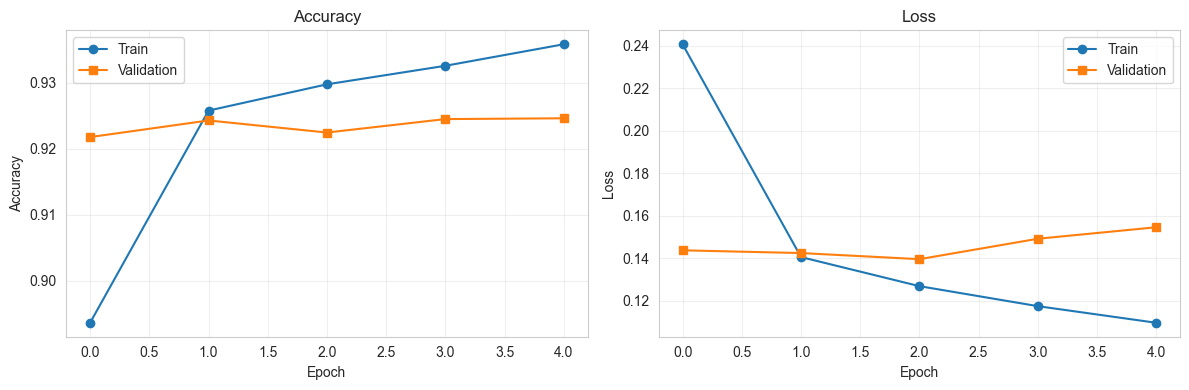

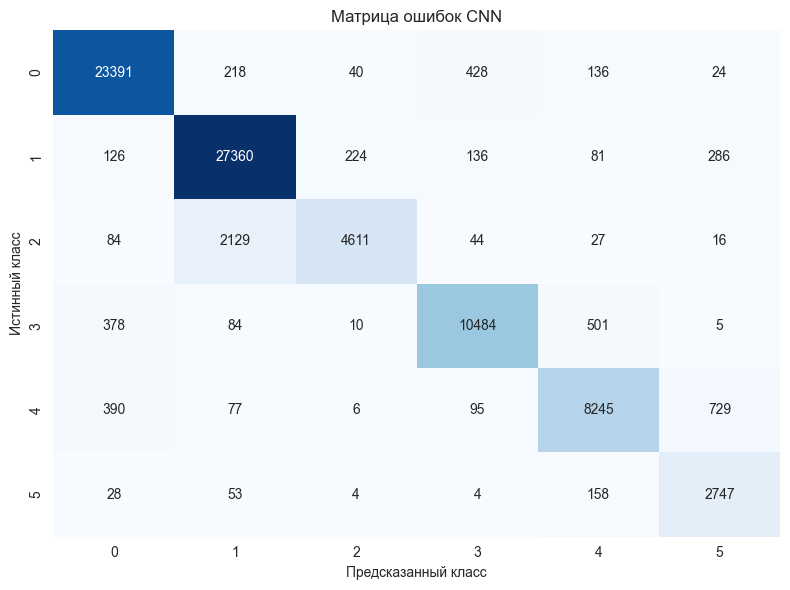


Отчет по классам:
              precision    recall  f1-score   support

           0      0.959     0.965     0.962     24237
           1      0.914     0.970     0.941     28213
           2      0.942     0.667     0.781      6911
           3      0.937     0.915     0.926     11462
           4      0.901     0.864     0.882      9542
           5      0.722     0.918     0.808      2994

    accuracy                          0.922     83359
   macro avg      0.896     0.883     0.883     83359
weighted avg      0.924     0.922     0.920     83359

✓ Модель сохранена локально: cnn_model.h5
✓ Токенизатор сохранен: tokenizer.pickle
✓ Конфигурация сохранена: model_config.json

CNN МОДЕЛЬ ОБУЧЕНА И ЗАЛОГИРОВАНА
✓ Accuracy: 0.9218
✓ F1 Macro: 0.8833
✓ Модель сохранена в MLflow


In [18]:
# Загружаем конфиг
cfg = load_config("cnn_experiment")

# Настройка MLflow
mlflow.set_tracking_uri(cfg.mlflow.tracking_uri)
mlflow.set_experiment(experiment_id=cfg.mlflow.experiment_id)

# Настройки визуализации
plt.style.use('default')
sns.set_style("whitegrid")

# Старт run
with mlflow.start_run(run_name=cfg.mlflow.run_name):
    
    # Устанавливаем теги
    for tag_key, tag_value in cfg.mlflow.tags.items():
        mlflow.set_tag(tag_key, tag_value)
    
    print("=" * 60)
    print("CNN ДЛЯ КЛАССИФИКАЦИИ ЭМОЦИЙ")
    print("=" * 60)
    
    # =====================================================================
    # 1. ЗАГРУЗКА ДАННЫХ
    # =====================================================================
    print("\n[1/6] Загрузка данных...")
    start_time = time.time()
    
    client = MlflowClient()
    
    # Ищем run с данными
    dataset_runs = client.search_runs(
        experiment_ids=[cfg.mlflow.experiment_id],
        filter_string="tags.mlflow.runName = 'Second_dataset_experiment'",
        order_by=['attributes.end_time desc']
    )
    
    if not dataset_runs:
        raise ValueError("Run 'Second_dataset_experiment' не найден")
    
    dataset_run = dataset_runs[0]
    dataset_run_id = dataset_run.info.run_id
    
    # Загружаем датасет
    artifact_path = cfg.data.artifact_path
    dataframe_path = client.download_artifacts(dataset_run_id, artifact_path)
    df = pd.read_csv(dataframe_path)
    
    print(f"✓ Загружено: {df.shape[0]:,} примеров")
    print(f"✓ Время: {time.time() - start_time:.2f} сек")
    
    # Логируем источник данных
    mlflow.log_params({
        'data_source': 'Second_dataset_experiment',
        'data_run_id': dataset_run_id
    })
    
    # =====================================================================
    # 2. ПОДГОТОВКА ДАННЫХ
    # =====================================================================
    print("\n[2/6] Подготовка данных...")
    
    # Проверяем колонки
    if 'processed_text' in df.columns and cfg.data.text_column not in df.columns:
        df = df.rename(columns={'processed_text': cfg.data.text_column})
    
    # Очистка NaN
    if cfg.preprocessing.clean_nan:
        initial_rows = len(df)
        df = df.dropna(subset=[cfg.data.text_column, cfg.data.label_column])
        df = df.reset_index(drop=True)
        print(f"✓ Очищено от NaN: {initial_rows - len(df)} строк")
    
    # Распределение классов
    labels_count = df[cfg.data.label_column].value_counts()
    print("\nРаспределение классов:")
    for label in sorted(labels_count.index):
        class_name = cfg.class_names.get(int(label), label)
        print(f"  {class_name}: {labels_count[label]:>7,} примеров")
    
    # Логируем распределение
    for label, count in labels_count.items():
        mlflow.log_metric(f"class_{label}_count", int(count))
    
    # =====================================================================
    # 3. ТОКЕНИЗАЦИЯ
    # =====================================================================
    print("\n[3/6] Токенизация...")
    
    X = df[cfg.data.text_column]
    y = df[cfg.data.label_column]
    
    # Разделение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=cfg.training.test_size, 
        random_state=cfg.training.random_state, 
        stratify=y
    )
    
    print(f"✓ Train: {len(X_train):,} примеров")
    print(f"✓ Test:  {len(X_test):,} примеров")
    
    # Токенизация
    tokenizer = Tokenizer(num_words=cfg.preprocessing.vocab_size)
    tokenizer.fit_on_texts(X_train)
    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    X_train_pad = pad_sequences(X_train_seq, maxlen=cfg.preprocessing.max_length, padding=cfg.preprocessing.padding)
    X_test_pad = pad_sequences(X_test_seq, maxlen=cfg.preprocessing.max_length, padding=cfg.preprocessing.padding)
    
    print(f"✓ Словарь: {cfg.preprocessing.vocab_size} слов")
    print(f"✓ Длина последовательности: {cfg.preprocessing.max_length}")
    
    # =====================================================================
    # 4. СОЗДАНИЕ МОДЕЛИ
    # =====================================================================
    print("\n[4/6] Создание модели CNN...")
    
    num_classes = len(np.unique(y))
    
    model = Sequential([
        Embedding(cfg.preprocessing.vocab_size, cfg.model.embedding_dim, input_length=cfg.preprocessing.max_length),
        Conv1D(cfg.model.conv_filters, cfg.model.conv_kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(cfg.model.dense_units, activation='relu'),
        Dropout(cfg.model.dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    
    # ИСПРАВЛЕНИЕ: Преобразуем ListConfig в обычный список
    metrics_list = list(cfg.model.metrics) if hasattr(cfg.model.metrics, '__iter__') else ['accuracy']
    
    model.compile(
        optimizer=cfg.model.optimizer,
        loss=cfg.model.loss,
        metrics=metrics_list  # Используем преобразованный список
    )
    
    # Краткий summary
    model.summary()
    
    # Логируем параметры модели
    mlflow.log_params({
        'vocab_size': cfg.preprocessing.vocab_size,
        'max_length': cfg.preprocessing.max_length,
        'embedding_dim': cfg.model.embedding_dim,
        'conv_filters': cfg.model.conv_filters,
        'conv_kernel_size': cfg.model.conv_kernel_size,
        'dense_units': cfg.model.dense_units,
        'dropout_rate': cfg.model.dropout_rate,
        'num_classes': num_classes
    })
    
    # =====================================================================
    # 5. ОБУЧЕНИЕ
    # =====================================================================
    print("\n[5/6] Обучение модели...")
    
    early_stop = EarlyStopping(
        monitor=cfg.training.early_stopping.monitor,
        patience=cfg.training.early_stopping.patience,
        restore_best_weights=cfg.training.early_stopping.restore_best_weights
    )
    
    history = model.fit(
        X_train_pad, y_train,
        validation_split=cfg.training.validation_split,
        epochs=cfg.training.epochs,
        batch_size=cfg.training.batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Логируем историю обучения
    for epoch in range(len(history.history['accuracy'])):
        mlflow.log_metric('train_accuracy', history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric('val_accuracy', history.history['val_accuracy'][epoch], step=epoch)
    
    # =====================================================================
    # 6. ОЦЕНКА
    # =====================================================================
    print("\n[6/6] Оценка модели...")
    
    # Предсказания
    y_pred_proba = model.predict(X_test_pad, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print("\n" + "="*50)
    print("РЕЗУЛЬТАТЫ")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Macro: {f1:.4f}")
    
    # Логируем финальные метрики
    mlflow.log_metrics({
        'accuracy': accuracy,
        'f1_score': f1
    })
    
    # Визуализация обучения
    if cfg.visualization.plot_history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.plot(history.history['accuracy'], label='Train', marker='o')
        ax1.plot(history.history['val_accuracy'], label='Validation', marker='s')
        ax1.set_title('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(history.history['loss'], label='Train', marker='o')
        ax2.plot(history.history['val_loss'], label='Validation', marker='s')
        ax2.set_title('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig("training_history.png")
        plt.show()
        mlflow.log_artifact("training_history.png", "viz")
    
    # Матрица ошибок
    if cfg.visualization.plot_confusion:
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Матрица ошибок CNN')
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        plt.show()
        mlflow.log_artifact("confusion_matrix.png", "viz")
    
    # Отчет по классам
    print("\nОтчет по классам:")
    print(classification_report(y_test, y_pred, digits=3))
    
    # =====================================================================
    # СОХРАНЕНИЕ МОДЕЛИ И ТОКЕНИЗАТОРА
    # =====================================================================
    
    # 1. Сохраняем модель в формате H5 (более совместимый)
    model.save("cnn_model.h5", save_format='h5')
    print(f"✓ Модель сохранена локально: cnn_model.h5")
    
    # 2. Логируем как артефакт в MLflow
    mlflow.log_artifact("cnn_model.h5", "models")
    
    # 3. Сохраняем токенизатор
    with open("tokenizer.pickle", 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f"✓ Токенизатор сохранен: tokenizer.pickle")
    
    # 4. Логируем токенизатор в MLflow
    mlflow.log_artifact("tokenizer.pickle", "models")
    
    # 5. Сохраняем конфигурацию модели для воспроизводимости
    model_config = {
        'vocab_size': cfg.preprocessing.vocab_size,
        'max_length': cfg.preprocessing.max_length,
        'embedding_dim': cfg.model.embedding_dim,
        'num_classes': num_classes,
        'class_names': dict(cfg.class_names),
        'padding': cfg.preprocessing.padding
    }
    
    with open("model_config.json", 'w') as f:
        json.dump(model_config, f, indent=2)
    mlflow.log_artifact("model_config.json", "models")
    print(f"✓ Конфигурация сохранена: model_config.json")
    
    print("\n" + "="*50)
    print("CNN МОДЕЛЬ ОБУЧЕНА И ЗАЛОГИРОВАНА")
    print("="*50)
    print(f"✓ Accuracy: {accuracy:.4f}")
    print(f"✓ F1 Macro: {f1:.4f}")
    print(f"✓ Модель сохранена в MLflow")

## 3 эксперимент -- LSTM

LSTM ДЛЯ КЛАССИФИКАЦИИ ЭМОЦИЙ (МИНИМАЛЬНАЯ ВЕРСИЯ)

[1/6] Загрузка данных...


✓ Загружено: 10,000 примеров
✓ Время: 14.16 сек

[2/6] Подготовка данных...
✓ Очищено от NaN: 2 строк

Распределение классов:
  neutral:   2,934 примеров
  joy:   3,396 примеров
  sadness:     789 примеров
  anger:   1,366 примеров
  fear:   1,149 примеров
  surprise:     364 примеров

[3/6] Токенизация...
✓ Train: 7,998 примеров
✓ Test:  2,000 примеров
✓ Словарь: 10000 слов
✓ Длина последовательности: 200

[4/6] Создание модели LSTM...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout 

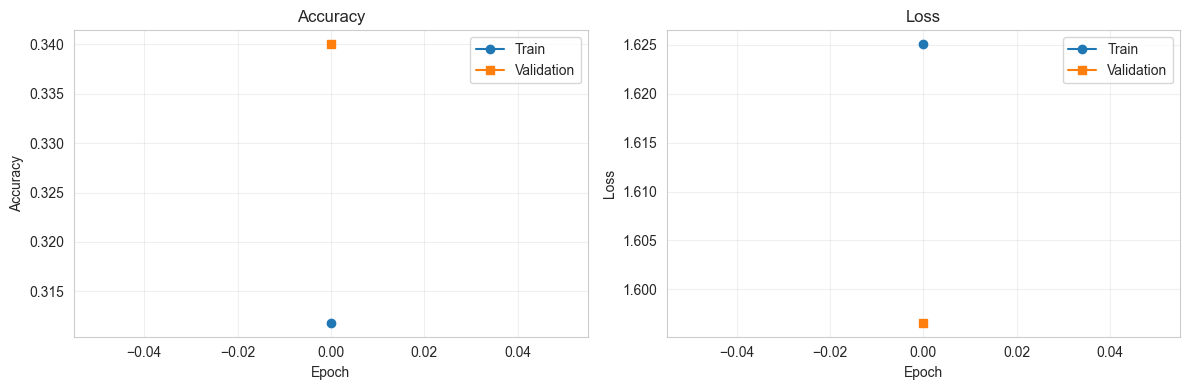

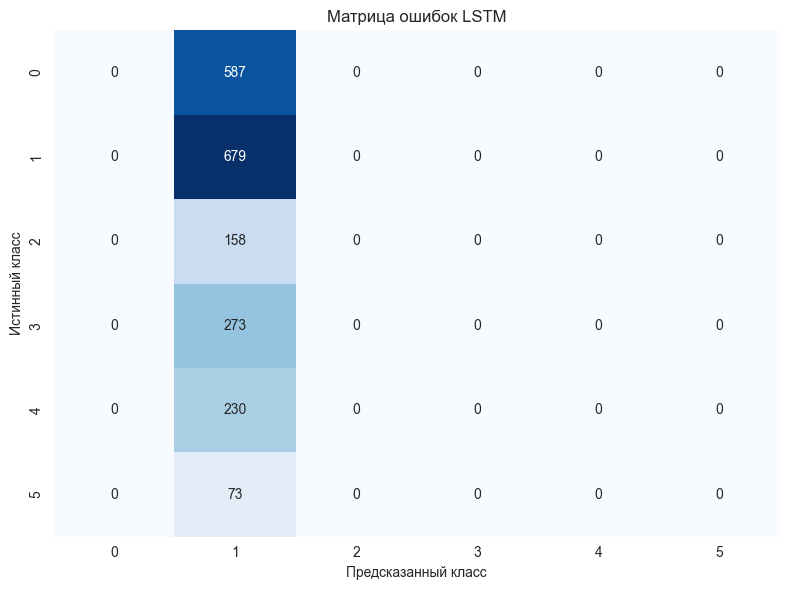


Отчет по классам:
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000       587
         joy      0.340     1.000     0.507       679
     sadness      0.000     0.000     0.000       158
       anger      0.000     0.000     0.000       273
        fear      0.000     0.000     0.000       230
    surprise      0.000     0.000     0.000        73

    accuracy                          0.340      2000
   macro avg      0.057     0.167     0.084      2000
weighted avg      0.115     0.340     0.172      2000

✓ Модель сохранена локально: lstm_model.h5
✓ Токенизатор сохранен: tokenizer.pickle
✓ Конфигурация сохранена: model_config.json

LSTM МОДЕЛЬ ОБУЧЕНА И ЗАЛОГИРОВАНА
✓ Accuracy: 0.3395
✓ F1 Macro: 0.0845
✓ Модель сохранена в MLflow
✓ Run ID: 4bf4fbfb2fbb4500b3f374fe5bcb85e0


In [29]:
# Минимальная версия LSTM эксперимента - ВСЕ ПАРАМЕТРЫ В КОДЕ

# Настройка MLflow
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment(experiment_id="0")

# Настройки визуализации
plt.style.use('default')
sns.set_style("whitegrid")

# СТАРТ RUN
with mlflow.start_run(run_name="LSTM_Minimal_v1.0"):
    
    print("=" * 60)
    print("LSTM ДЛЯ КЛАССИФИКАЦИИ ЭМОЦИЙ (МИНИМАЛЬНАЯ ВЕРСИЯ)")
    print("=" * 60)
    
    # =====================================================================
    # 1. ПАРАМЕТРЫ (ВСЕ ЗАДАЕМ ПРЯМО В КОДЕ)
    # =====================================================================
    PARAMS = {
        # Данные
        'text_column': 'span',
        'label_column': 'label',
        
        # Токенизация
        'vocab_size': 10000,
        'max_length': 200,
        'padding': 'post',
        
        # Модель
        'embedding_dim': 100,
        'lstm_units': 128,
        'dense_units': 64,
        'dropout_rate': 0.5,
        'recurrent_dropout': 0.2,
        'optimizer': 'adam',
        'loss': 'sparse_categorical_crossentropy',
        
        # Обучение
        'test_size': 0.2,
        'validation_split': 0.2,
        'random_state': 42,
        'epochs': 1,
        'batch_size': 64,
        
        # Имена классов
        'class_names': {
            0: "neutral",
            1: "joy", 
            2: "sadness",
            3: "anger",
            4: "fear",
            5: "surprise"
        }
    }
    
    # Логируем все параметры
    mlflow.log_params(PARAMS)
    
    # =====================================================================
    # 2. ЗАГРУЗКА ДАННЫХ
    # =====================================================================
    print("\n[1/6] Загрузка данных...")
    start_time = time.time()
    
    client = MlflowClient()
    
    # Ищем run с данными
    dataset_runs = client.search_runs(
        experiment_ids=["0"],
        filter_string="tags.mlflow.runName = 'Second_dataset_experiment'",
        order_by=['attributes.end_time desc']
    )
    
    if not dataset_runs:
        raise ValueError("Run 'Second_dataset_experiment' не найден")
    
    dataset_run = dataset_runs[0]
    dataset_run_id = dataset_run.info.run_id
    
    # Загружаем датасет
    artifact_path = "data/Dataset_2.csv"
    dataframe_path = client.download_artifacts(dataset_run_id, artifact_path)
    df = pd.read_csv(dataframe_path).head(10_000)
    
    print(f"✓ Загружено: {df.shape[0]:,} примеров")
    print(f"✓ Время: {time.time() - start_time:.2f} сек")
    
    mlflow.log_params({
        'data_source': 'Second_dataset_experiment',
        'data_run_id': dataset_run_id
    })
    
    # =====================================================================
    # 3. ПОДГОТОВКА ДАННЫХ
    # =====================================================================
    print("\n[2/6] Подготовка данных...")
    
    # Проверяем колонки
    if 'processed_text' in df.columns and PARAMS['text_column'] not in df.columns:
        df = df.rename(columns={'processed_text': PARAMS['text_column']})
    
    # Очистка NaN
    initial_rows = len(df)
    df = df.dropna(subset=[PARAMS['text_column'], PARAMS['label_column']])
    df = df.reset_index(drop=True)
    print(f"✓ Очищено от NaN: {initial_rows - len(df)} строк")
    
    # Распределение классов
    labels_count = df[PARAMS['label_column']].value_counts()
    print("\nРаспределение классов:")
    
    for label in sorted(labels_count.index):
        class_name = PARAMS['class_names'].get(int(label), f"class_{label}")
        print(f"  {class_name}: {labels_count[label]:>7,} примеров")
    
    # Логируем распределение
    for label, count in labels_count.items():
        mlflow.log_metric(f"class_{label}_count", int(count))
    
    # =====================================================================
    # 4. ТОКЕНИЗАЦИЯ И РАЗДЕЛЕНИЕ
    # =====================================================================
    print("\n[3/6] Токенизация...")
    
    X = df[PARAMS['text_column']]
    y = df[PARAMS['label_column']]
    
    # Разделение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=PARAMS['test_size'],
        random_state=PARAMS['random_state'], 
        stratify=y
    )
    
    print(f"✓ Train: {len(X_train):,} примеров")
    print(f"✓ Test:  {len(X_test):,} примеров")
    
    # Токенизация
    tokenizer = Tokenizer(num_words=PARAMS['vocab_size'])
    tokenizer.fit_on_texts(X_train)
    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    X_train_pad = pad_sequences(X_train_seq, maxlen=PARAMS['max_length'], padding=PARAMS['padding'])
    X_test_pad = pad_sequences(X_test_seq, maxlen=PARAMS['max_length'], padding=PARAMS['padding'])
    
    print(f"✓ Словарь: {PARAMS['vocab_size']} слов")
    print(f"✓ Длина последовательности: {PARAMS['max_length']}")
    
    # =====================================================================
    # 5. СОЗДАНИЕ МОДЕЛИ LSTM
    # =====================================================================
    print("\n[4/6] Создание модели LSTM...")

    num_classes = len(np.unique(y))

    model = Sequential([
        Embedding(PARAMS['vocab_size'], PARAMS['embedding_dim'], input_length=PARAMS['max_length']),
        LSTM(PARAMS['lstm_units'], dropout=PARAMS['dropout_rate'], 
             recurrent_dropout=PARAMS['recurrent_dropout'], 
             return_sequences=False),
        Dense(PARAMS['dense_units'], activation='relu'),
        Dropout(PARAMS['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])

    # Компиляция
    model.compile(
        optimizer=PARAMS['optimizer'],
        loss=PARAMS['loss'],
        metrics=['accuracy']
    )

    model.summary()
    
    # =====================================================================
    # 6. ОБУЧЕНИЕ
    # =====================================================================
    print("\n[5/6] Обучение модели...")
    
    history = model.fit(
        X_train_pad, y_train,
        validation_split=PARAMS['validation_split'],
        epochs=PARAMS['epochs'],
        batch_size=PARAMS['batch_size'],
        verbose=1
    )
    
    # Логируем историю обучения
    for epoch in range(len(history.history['accuracy'])):
        mlflow.log_metric('train_accuracy', history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric('val_accuracy', history.history['val_accuracy'][epoch], step=epoch)
    
    # =====================================================================
    # 7. ОЦЕНКА
    # =====================================================================
    print("\n[6/6] Оценка модели...")
    
    # Предсказания
    y_pred_proba = model.predict(X_test_pad, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print("\n" + "="*50)
    print("РЕЗУЛЬТАТЫ")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Macro: {f1:.4f}")
    
    # Логируем финальные метрики
    mlflow.log_metrics({
        'accuracy': accuracy,
        'f1_score': f1
    })
    
    # =====================================================================
    # 8. ВИЗУАЛИЗАЦИИ
    # =====================================================================
    # История обучения
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['accuracy'], label='Train', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation', marker='s')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['loss'], label='Train', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation', marker='s')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("training_history.png")
    plt.show()
    mlflow.log_artifact("training_history.png", "viz")
    
    # Матрица ошибок
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Матрица ошибок LSTM')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()
    mlflow.log_artifact("confusion_matrix.png", "viz")
    
    # Отчет по классам
    print("\nОтчет по классам:")
    target_names = [PARAMS['class_names'].get(i, f"class_{i}") for i in range(num_classes)]
    print(classification_report(y_test, y_pred, digits=3, target_names=target_names))
    
    # =====================================================================
    # 9. СОХРАНЕНИЕ
    # =====================================================================
    # Сохраняем модель
    model.save("lstm_model.h5", save_format='h5')
    print(f"✓ Модель сохранена локально: lstm_model.h5")
    mlflow.log_artifact("lstm_model.h5", "models")
    
    # Сохраняем токенизатор
    with open("tokenizer.pickle", 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f"✓ Токенизатор сохранен: tokenizer.pickle")
    mlflow.log_artifact("tokenizer.pickle", "models")
    
    # Сохраняем конфигурацию
    model_config = {
        'vocab_size': PARAMS['vocab_size'],
        'max_length': PARAMS['max_length'],
        'embedding_dim': PARAMS['embedding_dim'],
        'lstm_units': PARAMS['lstm_units'],
        'dense_units': PARAMS['dense_units'],
        'dropout_rate': PARAMS['dropout_rate'],
        'num_classes': num_classes,
        'class_names': PARAMS['class_names'],
        'padding': PARAMS['padding']
    }
    
    with open("model_config.json", 'w') as f:
        json.dump(model_config, f, indent=2)
    print(f"✓ Конфигурация сохранена: model_config.json")
    mlflow.log_artifact("model_config.json", "models")
    
    print("\n" + "="*50)
    print("LSTM МОДЕЛЬ ОБУЧЕНА И ЗАЛОГИРОВАНА")
    print("="*50)
    print(f"✓ Accuracy: {accuracy:.4f}")
    print(f"✓ F1 Macro: {f1:.4f}")
    print(f"✓ Модель сохранена в MLflow")
    print(f"✓ Run ID: {mlflow.active_run().info.run_id}")